In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
2018-05-15 23:34:06,153 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import Dropout, GlobalAveragePooling1D
from keras.layers import Flatten, Activation, Concatenate
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score

/home/nikita/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:100000]
test_batch = test_data[0:50000]

In [5]:
def build_sentences_vector(sentence):
    words = sentence.split()
    result = np.zeros(100)
    size = 0
    for word in words:
        if word in embeding_model.wv.vocab:
            result+=embeding_model.wv[word]
            size+=1
    if size == 0:
        size = 1
    result /= size
    return result

In [6]:
embeding_model = Word2Vec.load('Yelp_embedings')
len(embeding_model.wv.vocab)

2018-05-15 23:35:06,367 : INFO : loading Word2Vec object from Yelp_embedings
2018-05-15 23:35:11,701 : INFO : loading wv recursively from Yelp_embedings.wv.* with mmap=None
2018-05-15 23:35:11,702 : INFO : setting ignored attribute vectors_norm to None
2018-05-15 23:35:11,703 : INFO : loading vocabulary recursively from Yelp_embedings.vocabulary.* with mmap=None
2018-05-15 23:35:11,704 : INFO : loading trainables recursively from Yelp_embedings.trainables.* with mmap=None
2018-05-15 23:35:11,705 : INFO : setting ignored attribute cum_table to None
2018-05-15 23:35:11,707 : INFO : loaded Yelp_embedings


101865

In [7]:
%%time
train_data_features = []
for sentense in train_batch.text:
    train_data_features.append(build_sentences_vector(sentense))
test_data_transform = []
for sentense in test_batch.text:
    test_data_transform.append(build_sentences_vector(sentense))

CPU times: user 56 s, sys: 170 ms, total: 56.2 s
Wall time: 56 s


In [8]:
train_data_features = pd.DataFrame(train_data_features)
test_data_transform = pd.DataFrame(test_data_transform)

In [9]:
%%time
big_X = train_data_features.append(test_data_transform)
scaler = MinMaxScaler()
scaler.fit(big_X)
train_data_features = scaler.transform(train_data_features)
test_data_transform = scaler.transform(test_data_transform)

CPU times: user 178 ms, sys: 157 ms, total: 334 ms
Wall time: 335 ms


In [10]:
print(train_data_features.shape, test_data_transform.shape)
print(train_data_features[0].shape, test_data_transform[0].shape)

(100000, 100) (50000, 100)
(100,) (100,)


In [17]:
batch_size = 100
num_classes = 6
epochs = 30
# input image dimensions
text_x, text_y = 10, 10

In [12]:
train_data_features[0].shape
x_train = train_data_features.reshape(train_data_features.shape[0], text_x, text_y, 1)
y_train = test_data_transform.reshape(test_data_transform.shape[0], text_x, text_y, 1)
input_shape = (text_x, text_y, 1)

In [13]:
x_train.shape

(100000, 10, 10, 1)

In [14]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 10, 64)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         8320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total para

In [15]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
history = AccuracyHistory()

In [16]:
Y = np_utils.to_categorical(train_batch.stars)
print(Y)

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [18]:
%%time
model.fit(x_train, np.array(Y),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.15,
          callbacks=[history])

Train on 85000 samples, validate on 15000 samples
Epoch 1/30
85000/85000 [==============================] - 19s 229us/step - loss: 1.4377 - acc: 0.4303 - val_loss: 1.4187 - val_acc: 0.4267
Epoch 2/30
85000/85000 [==============================] - 17s 200us/step - loss: 1.3498 - acc: 0.4466 - val_loss: 1.3192 - val_acc: 0.4571
Epoch 3/30
85000/85000 [==============================] - 17s 201us/step - loss: 1.2974 - acc: 0.4663 - val_loss: 1.2448 - val_acc: 0.4941
Epoch 4/30
85000/85000 [==============================] - 17s 201us/step - loss: 1.2293 - acc: 0.4953 - val_loss: 1.2043 - val_acc: 0.5053
Epoch 5/30
85000/85000 [==============================] - 17s 198us/step - loss: 1.2038 - acc: 0.5039 - val_loss: 1.1830 - val_acc: 0.5111
Epoch 6/30
85000/85000 [==============================] - 17s 202us/step - loss: 1.1872 - acc: 0.5113 - val_loss: 1.1779 - val_acc: 0.5123
Epoch 7/30
85000/85000 [==============================] - 17s 200us/step - loss: 1.1770 - acc: 0.5144 - val_loss: 1.

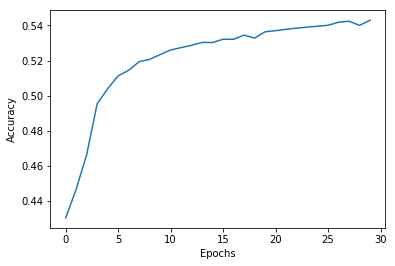

In [19]:
plt.plot(range(epochs), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()